# 🛒 Shopper Spectrum Project
Customer Segmentation and Product Recommendation in E-Commerce

## 📥 Step 1: Load and Preprocess Dataset

In [5]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('/Users/shreyadas/Desktop/online_retail.csv', encoding='ISO-8859-1')

# Initial inspection
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


### ✅ Clean the data

In [6]:
# Drop missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Remove cancelled invoices
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove negative or zero Quantity and UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.shape


(397884, 8)

## 📊 Step 2: Exploratory Data Analysis (EDA)

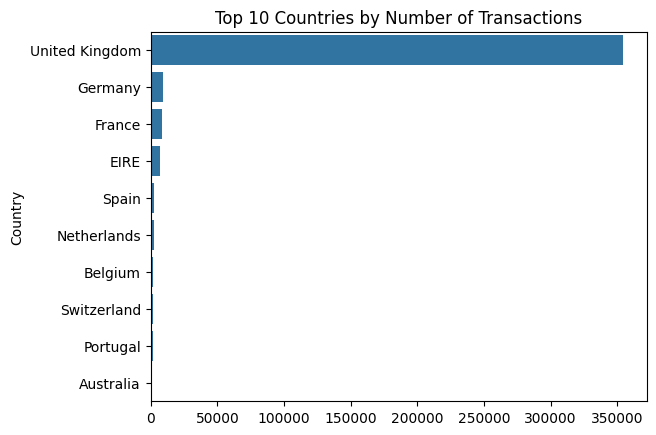

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 countries by transactions
country_counts = df['Country'].value_counts().head(10)
sns.barplot(x=country_counts.values, y=country_counts.index)
plt.title("Top 10 Countries by Number of Transactions")
plt.show()


## 📈 Step 3: RFM Feature Engineering

In [8]:
# Latest date
latest_date = df['InvoiceDate'].max()

# RFM Table
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'UnitPrice': lambda x: (x * df.loc[x.index, 'Quantity']).sum()
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,7,4310.00
12348.0,74,4,1797.24
12349.0,18,1,1757.55
12350.0,309,1,334.40


## 🔍 Step 4: Clustering - KMeans

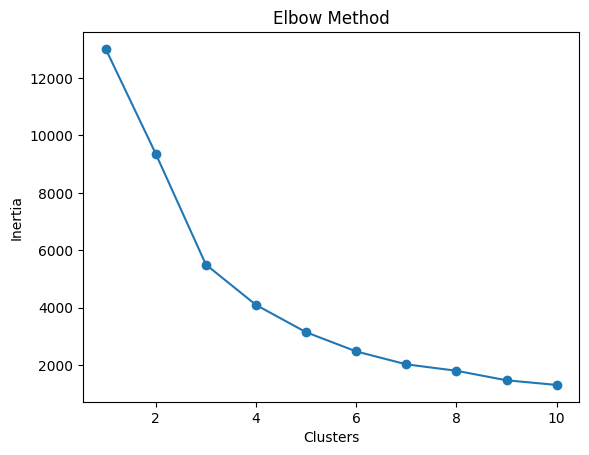

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Normalize
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


In [10]:
# Choose optimal cluster (e.g., k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Interpret clusters
cluster_summary = rfm.groupby('Cluster').mean()
cluster_summary


,Recency,Frequency,Monetary
Cluster,,,
0,42.702685,3.682711,1359.049284
1,247.075914,1.552015,480.617480
2,6.384615,82.538462,127338.313846
3,14.500000,22.333333,12709.090490


## 🎯 Step 5: Product Recommendation System

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

# Create customer-item matrix
pivot = df.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', aggfunc='sum', fill_value=0)

# Cosine similarity
item_sim = cosine_similarity(pivot.T)
item_sim_df = pd.DataFrame(item_sim, index=pivot.columns, columns=pivot.columns)

# Recommendation function
def recommend_products(product_code, top_n=5):
    similar_items = item_sim_df[product_code].sort_values(ascending=False)[1:top_n+1]
    return similar_items

# Example usage
recommend_products('85123A')  # Change to a real product code from the dataset


StockCode
21175    0.749651
21733    0.658732
82552    0.643868
82551    0.642480
23288    0.630982
Name: 85123A, dtype: float64

In [12]:
import joblib

joblib.dump(kmeans, 'kmeans_model.pkl')
item_sim_df.to_pickle('item_similarity.pkl')
